In [19]:
import pandas as pd
import numpy as np
import math
from datetime import date
from datetime import datetime, timedelta
import pytz
from tqdm.notebook import tqdm, trange
import time

# For model formulation
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from sklearn.model_selection import RandomizedSearchCV

**Section 1: Data Cleaning**

While we may not have to do much data cleaning itself, we do need to decide on the features we will use to predict the outcome of a game (away win, home win, draw).

In [ ]:
all_data = pd.read_csv("./data/epl_06_20_raw.csv")
all_data["Date"] = pd.to_datetime(all_data['Date'])
all_data["HomeTeam"] = all_data["HomeTeam"].astype(str)
all_data["AwayTeam"] = all_data["AwayTeam"].astype(str)
all_data['HT_win_rate_season'] = all_data['HT_win_rate_season'].fillna(0)
all_data['AT_win_rate_season'] = all_data['AT_win_rate_season'].fillna(0)

# Filter out games that haven't happened
epl_susp_date = datetime(2020, 3, 13)

all_data = all_data[all_data['Date'] < epl_susp_date]

In [ ]:
# Create season column for ELO purposes
epl_start_06_07 = datetime(2006, 8, 19)
epl_start_07_08 = datetime(2007, 8, 11)
epl_start_08_09 = datetime(2008, 8, 16)
epl_start_09_10 = datetime(2009, 8, 15)
epl_start_10_11 = datetime(2010, 8, 14)
epl_start_11_12 = datetime(2011, 8, 13)
epl_start_12_13 = datetime(2012, 8, 18)
epl_start_13_14 = datetime(2013, 8, 17)
epl_start_14_15 = datetime(2014, 8, 16)
epl_start_15_16 = datetime(2015, 8, 8)
epl_start_16_17 = datetime(2016, 8, 13)
epl_start_17_18 = datetime(2017, 8, 11)
epl_start_18_19 = datetime(2018, 8, 11)
epl_start_19_20 = datetime(2019, 8, 9)

season_data = {"season": []}
for index, row in all_data.iterrows():
    game_date = row["Date"]
    if game_date > epl_start_19_20:
        season_data["season"].append("19_20")
    elif game_date > epl_start_18_19:
        season_data["season"].append("18_19")
    elif game_date > epl_start_17_18:
        season_data["season"].append("17_18")
    elif game_date > epl_start_16_17:
        season_data["season"].append("16_17")
    elif game_date > epl_start_15_16:
        season_data["season"].append("15_16")
    elif game_date > epl_start_14_15:
        season_data["season"].append("14_15")
    elif game_date > epl_start_13_14:
        season_data["season"].append("13_14")
    elif game_date > epl_start_12_13:
        season_data["season"].append("12_13")
    elif game_date > epl_start_11_12:
        season_data["season"].append("11_12")
    elif game_date > epl_start_10_11:
        season_data["season"].append("10_11")
    elif game_date > epl_start_09_10:
        season_data["season"].append("09_10")
    elif game_date > epl_start_08_09:
        season_data["season"].append("08_09")
    elif game_date > epl_start_07_08:
        season_data["season"].append("07_08")
    elif game_date > epl_start_06_07:
        season_data["season"].append("06_07")
    
season_df = pd.DataFrame(season_data)

all_data['season'] = season_df['season']

Instead of using the provided "OVA" dating system, we will again use an ELO based system like used in NBA adjusted for goal differential with a modified k value.

In [ ]:
def get_post_elos(elo_h_pre, elo_a_pre, goal_diff):
  if goal_diff < 0:
    O_h = 0
    O_a = 1
  elif goal_diff == 0:
    O_h = 0.5
    O_a = 0.5
  else:
    O_h = 1
    O_a = 0

  K = 20
  home_ad = 65
  dr = elo_h_pre - elo_a_pre + home_ad
  E_h = 1.0 / (1 + 10**(-dr / 400.0))
  E_a = 1 - E_h

  # print(str(E_h) + " " + str(E_a))

  # print(goal_diff)
  G = 1
  if abs(goal_diff) > 1:
    G = math.log2(1.7 * abs(goal_diff)) * 2 / (2 + 0.001 * dr)
  # elif abs(goal_diff) == 2:
  #   G = 1.5
  # else:
  #   G = (11 + abs(goal_diff)) / 8

  # if goal_diff < 0:
  #   G = -G

  elo_h_post = elo_h_pre + K * G * (O_h - E_h)
  elo_a_post = elo_a_pre + K * G * (O_a - E_a)

  return elo_h_post, elo_a_post

def get_prev_elo(team, date, season, elo_df):
    prev_games = elo_df[elo_df['date'] <= date]
    prev_game = prev_games[(prev_games['h_team'] == team) | (prev_games['a_team'] == team)].sort_values(by='date', ascending=True).tail(1)
    if team == prev_game['h_team'].values[0]:
      elo_rating = prev_game['h_elo_after'].values[0]
    else:
      elo_rating = prev_game['a_elo_after'].values[0]

    if prev_game['season'].values[0] != season:
      return (0.75 * elo_rating) + (0.25 * 1505)
    else :
      return elo_rating

In [ ]:
elo_df = pd.DataFrame(columns=['date', 'season', 'goal_diff', 'h_team', 'a_team', 'h_elo_before', 'a_elo_before', 'h_elo_after', 'a_elo_after'])

p_bar = tqdm(total=len(all_data))
for index, row in all_data.iterrows(): 

    game_date = row['Date']
    season = row['season']
    h_team, a_team = str(row['HomeTeam']), str(row['AwayTeam'])
    goal_diff = row['FTHG'] - row['FTAG']

    if (h_team not in elo_df['h_team'].values and h_team not in elo_df['a_team'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, elo_df)

    if (a_team not in elo_df['h_team'].values and a_team not in elo_df['a_team'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, elo_df)

    h_team_elo_after, a_team_elo_after = get_post_elos(h_team_elo_before, a_team_elo_before, goal_diff)

    new_row = {'h_team': h_team, 'a_team': a_team, 'h_elo_before': \
        h_team_elo_before, 'a_elo_before': a_team_elo_before, 'h_elo_after' : h_team_elo_after, \
        'a_elo_after': a_team_elo_after, 'date': game_date, 'goal_diff': goal_diff, 'season': season}
  
    elo_df = elo_df.append(new_row, ignore_index = True)

    p_bar.update(1)

We also must account for the fact that the past 5 game winrate when less than 5 games have been played by a team

In [ ]:
# Set past 5 winrate to total winrate if less than 5 games
past_5_winrate_data = {
    'h_win_percent_last_5': [],
    'a_win_percent_last_5': [],
}

p_bar = tqdm(total=len(all_data))
for index, row in all_data.iterrows(): 

    # Home
    if row['HT_match_played'] < 5:
        past_5_winrate_data['h_win_percent_last_5'].append(row['HT_win_rate_season'])
    else:
        past_5_winrate_data['h_win_percent_last_5'].append(row['HT_5_win_rate'])

    # Away
    if row['AT_match_played'] < 5:
        past_5_winrate_data['a_win_percent_last_5'].append(row['AT_win_rate_season'])
    else:
        past_5_winrate_data['a_win_percent_last_5'].append(row['AT_5_win_rate'])

    p_bar.update(1)

past_5_winrate_df = pd.DataFrame(past_5_winrate_data)

For the last step in this process, we will create our dataframe that we will use to train/test

In [ ]:
training_df = pd.DataFrame()
training_df['h_elo_before'] = elo_df['h_elo_before']
training_df['a_elo_before'] = elo_df['a_elo_before']
training_df['result'] = all_data['FTR']
training_df['h_match_played'] = all_data['HT_match_played']
training_df['h_goal_diff'] = all_data['HT_goal_diff']
training_df['h_win_percent'] = all_data['HT_win_rate_season']
training_df['h_win_percent_last_5'] = past_5_winrate_df['h_win_percent_last_5']
training_df['a_match_played'] = all_data['AT_match_played']
training_df['a_goal_diff'] = all_data['AT_goal_diff']
training_df['a_win_percent'] = all_data['AT_win_rate_season']
training_df['a_win_percent_last_5'] = past_5_winrate_df['a_win_percent_last_5']
training_df['goal_diff_diff'] = all_data['HT_goal_diff'] - all_data['AT_goal_diff']

training_df.head()

In [ ]:
training_df.to_csv( "./data/training_df.csv", index=False)

**Section 2: Training a Model**

Like with any ML process, we will proceed by generating a model to predict the outcome of an EPL game (i.e. home win, away win or draw). We will test several models and choose the one that gives us the best accuracy (and lowest error).

In [12]:
training_df = pd.read_csv("./data/training_df.csv", index_col=False)
training_df = training_df.loc[:, ~training_df.columns.str.contains('^Unnamed')]

In [13]:
# Relabel truth value column
training_df['result'] = training_df['result'].replace(['H'], 0)
training_df['result'] = training_df['result'].replace(['D'], 1)
training_df['result'] = training_df['result'].replace(['A'], 2)
training_df['result'] = training_df['result'].astype(int)

Logistic Regression:

In [14]:
y = training_df['result']
training_df.drop(columns=['result'], inplace=True)
X = training_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X.head()

,h_elo_before,a_elo_before,h_match_played,h_goal_diff,h_win_percent,h_win_percent_last_5,a_match_played,a_goal_diff,a_win_percent,a_win_percent_last_5,goal_diff_diff
0,1500.0,1500.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,1500.0,1500.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,1500.0,1500.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,1500.0,1500.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,1500.0,1500.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [ ]:
log_clf = LogisticRegression(random_state=23, max_iter=1000)
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

log_clf_cv = GridSearchCV(log_clf, param_grid, cv=5)
log_clf_cv.fit(X, y)

print("Tuned Logistic Regression Parameters: {}".format(log_clf_cv.best_params_))
print("Best score is {}".format(log_clf_cv.best_score_))

In [ ]:
mse = mean_squared_error(log_clf_cv.predict(X_test), y_test)
mse

KNN

In [ ]:
leaf_size = [5, 30]
n_neighbors = [10, 30, 50, 70]
p=[1,2]

# Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# Create new KNN object
knn_clf = KNeighborsClassifier()

# Use GridSearch
knn_clf_cv = GridSearchCV(knn_clf, hyperparameters, cv=10, verbose=2)

# Fit the model
best_model_knn = knn_clf_cv.fit(X,y)

# Print The value of best Hyperparameters
print('Best leaf_size:', best_model_knn.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model_knn.best_estimator_.get_params()['n_neighbors'])

In [ ]:
print(best_model_knn.classes_)
knn_probs = best_model_knn.predict_proba(X_test)
mse = mean_squared_error(best_model_knn.predict(X_test), y_test)
mse

XGBoost

In [21]:
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

# data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_clf = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xgb_rscv = RandomizedSearchCV(xg_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )
model_xgboost = xgb_rscv.fit(X_train, y_train)

# xg_clf.fit(X_train,y_train)
# params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}
# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
# cv_results.tail()

NameError: name 'target_train' is not defined

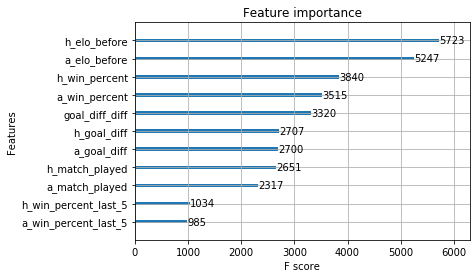

<Figure size 1152x864 with 0 Axes>

In [31]:
xgb.plot_importance(model_xgboost.best_estimator_._Booster)
plt.figure(figsize = (16, 12))
plt.show()
# model_xgboost.best_estimator_.feature_importance()

In [17]:
xg_probs = model_xgboost.predict_proba(X_test)

In [18]:
y_test_pred = model_xgboost.predict(X_test)
mse = mean_squared_error(y_test_pred, y_test)
mse

1.098470363288719

In [32]:
pickle.dump(model_xgboost, open('../../alderaan/epl_pregame_prediction.pkl', 'wb'))

SVC

In [ ]:
svc_clf = SVC(probability=True)
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svc_cv = GridSearchCV(svc_clf, param_grid, refit = True, verbose = 3)
svc_cv.fit(X_train, y_train)

print(svc_cv.best_params_)
print(svc_cv.best_estimator_)

In [ ]:
grid_predictions = svc_cv.predict(X_test)
print(classification_report(y_test, grid_predictions))
mse = mean_squared_error(grid_predictions, y_test)
mse

In [ ]:
svc_probs = svc_cv.predict_proba(X_test)

In the end, the SVC model and XGB gave us comparable MSE's but the feature importance of the XG boost model was more reliable. (accounting for the fact that the KNN model simply chose the home team most times).